# Título

## Antonio Drago Caetano

https://www.linkedin.com/in/antoniodragoc/

https://github.com/dragoc1

# Introdução

# Descrição dos dados

# Objetivos e análises

# Importação das Bibliotecas

In [44]:
# importações padrões
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(225)

In [45]:
# Importações do scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

In [46]:
import warnings

#ignorar os avisos do python
warnings.filterwarnings('ignore')

# Definindo as funções

In [47]:
def checa_na(data):

    """   
    Função com o objetivo de checar a quantidade de elementos nulos no dataframe   
    ---------------------------------------------------------------
    Parâmetros: DataFrame 
    """
    
    # checando a quantidade de valores nulos
    null_sum = data.isnull().sum() #Criando as colunas
    total = null_sum.sort_values(ascending=False) #Número total
    percent = ( ((null_sum / len(data.index))*100).round(2) ).sort_values(ascending=False)
    
    # Criando colunas de valores totais e valores missing
    df_NA = pd.concat([total, percent], axis=1, keys=['Number of NA', 'Percent NA'])
    
    # Removendo linhas que não possuem valores faltantes
    #df_NA = df_NA[ (df_NA.T != 0).any() ]
    
    return df_NA

In [48]:
def preenche_tabela(dados):

    """
    Função para preencher os dados missing repetindo os valores anteriores ou posteriores.    
    ---------------------------------------------------------------
    Parâmetros: DataFrame 
    """
    
    # Lendo a documentação dos dados sabemos que as features contínus são todas da coluna 13 até a anti-penúltima
    features_continuas_colunas = dados.iloc[:,13:-2].columns # No iloc, Não pegar nada do inicio (signifca que estamos pegando todas as linhas) e do final pegar as colunas entre 13 e a -2

    # Agrupando pelo identificador do paciente e preenchendo os valores nulos anteriores(bfill) e posteriores(ffill)
    features_continuas = dados.groupby('PATIENT_VISIT_IDENTIFIER', as_index= False)[features_continuas_colunas].fillna(method = 'bfill').fillna(method = 'ffill')


    # Pegando todas as linhas das colunas 0 até 13
    features_categoricas = dados.iloc[:,:13]
    # Pegando a Saída, todas as linhas das colunas -2 em diantes, ou seja, as duas últimas colunas apenas

    saida = dados.iloc[:,-2:]

    # Juntando as partes dos dados: 1 - parte não alterou nada, 2 - limpou e agrupou os dados e 3 - pegou os dados de saída
    dados_finais = pd.concat([features_categoricas, features_continuas, saida], ignore_index= True, axis  = 1 ) # Como argumento do pd.concat deve ser sempre uma lista, Ignorar o index que não está sendo utilizado (como todos tem o mesmo número de linhas, basta encaixar diretamente) e axis 1 para buscar os dados nas colunas e não nas linhas
    
    dados_finais.columns = dados.columns
    return dados_finais


In [49]:
def prepare_window(rows):
    """
    Identifica as linhas onde a janela é '0-2' e o valor de ICU é '  
    ---------------------------------------------------------------
    Parâmetros: linhas do Dataframe 
    
    """
    
    if(np.any(rows['ICU'])):
        rows.loc[rows['WINDOW'] == '0-2', 'ICU'] = 1 # Buscando as linhas em que a janela é "0-2" e ICU é 1

        
    return rows.loc[rows['WINDOW'] == '0-2'] 

# Importação dos Dados

In [50]:
from zipfile import ZipFile
#zf = ZipFile(r'./dados/archive.zip')
#dados = pd.read_excel(zf.open('Kaggle_Sirio_Libanes_ICU_Prediction.xlsx'))

url = 'https://github.com/dragoc1/projeto_final_bootcamp_alura/raw/master/dados/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx'
dados = pd.read_excel(url)

# Limpeza dos Dados

In [51]:
dados.shape

(1925, 231)

In [52]:
dados.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


In [53]:
dados.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1925.000000,1925.000000,1925.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,...,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1925.000000
mean,192.000000,0.467532,0.368831,0.108333,0.028125,0.097917,0.019792,0.128125,0.046875,0.213021,...,-0.703683,-0.770338,-0.887196,-0.786997,-0.715950,-0.817800,-0.719147,-0.771327,-0.886982,0.267532
std,111.168431,0.499074,0.482613,0.310882,0.165373,0.297279,0.139320,0.334316,0.211426,0.409549,...,0.482097,0.319001,0.296147,0.324754,0.419103,0.270217,0.446600,0.317694,0.296772,0.442787
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,96.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,192.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-0.976190,-0.979798,-1.000000,-0.984944,-0.989822,-1.000000,-0.975924,-0.980333,0.000000
75%,288.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.647059,-0.595238,-0.878788,-0.645482,-0.522176,-0.662529,-0.634409,-0.594677,-0.880155,1.000000
max,384.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [54]:
checa_na(dados).head(20)

,Number of NA,Percent NA
P02_VENOUS_MIN,1104,57.35
LEUKOCYTES_MAX,1104,57.35
PC02_VENOUS_MEAN,1104,57.35
PC02_VENOUS_MIN,1104,57.35
PC02_VENOUS_MAX,1104,57.35
PC02_VENOUS_DIFF,1104,57.35
PCR_MEDIAN,1104,57.35
PCR_MEAN,1104,57.35
PCR_MIN,1104,57.35
PCR_MAX,1104,57.35


In [55]:
(dados.isnull().sum().sum())/(len(dados)*len(dados.columns))*100

50.34305953786473

Podemos observar que 50,34% dos dados são nulos, logo será necessário preencher tais valores repetindo os dados anteriores ou posteriores existentes

## Preenchendo os valores nulos

In [56]:
dados = preenche_tabela(dados)
dados.dropna(inplace = True)

In [57]:
dados.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,...,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000
mean,191.981771,0.468750,0.369792,0.108333,0.028125,0.097917,0.019792,0.128125,0.046875,0.213021,...,-0.758150,-0.812388,-0.910214,-0.818008,-0.759122,-0.848720,-0.771187,-0.813295,-0.910085,0.268229
std,111.312587,0.499152,0.482874,0.310882,0.165373,0.297279,0.139320,0.334316,0.211426,0.409549,...,0.433588,0.296775,0.255728,0.301726,0.389598,0.247117,0.401430,0.295619,0.256368,0.443153
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,95.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,191.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
75%,288.250000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.705882,-0.690476,-0.919192,-0.710805,-0.622483,-0.764487,-0.725806,-0.698390,-0.918403,1.000000
max,384.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Análise exploratória

Será levado em consideração apenas as duas primeiras horas do paciente no hospital, ou seja, a janela de tempo em que WINDOW = '0-2'.

Iremos excluir também os pacientes que já chegaram no hospital e foram na UTI na primeira janela de tempo.

In [58]:
dados_limpos = dados.groupby('PATIENT_VISIT_IDENTIFIER', as_index= False).apply(prepare_window).reset_index(drop = True) # Aplicando a função que busca os valores de janela 0-2

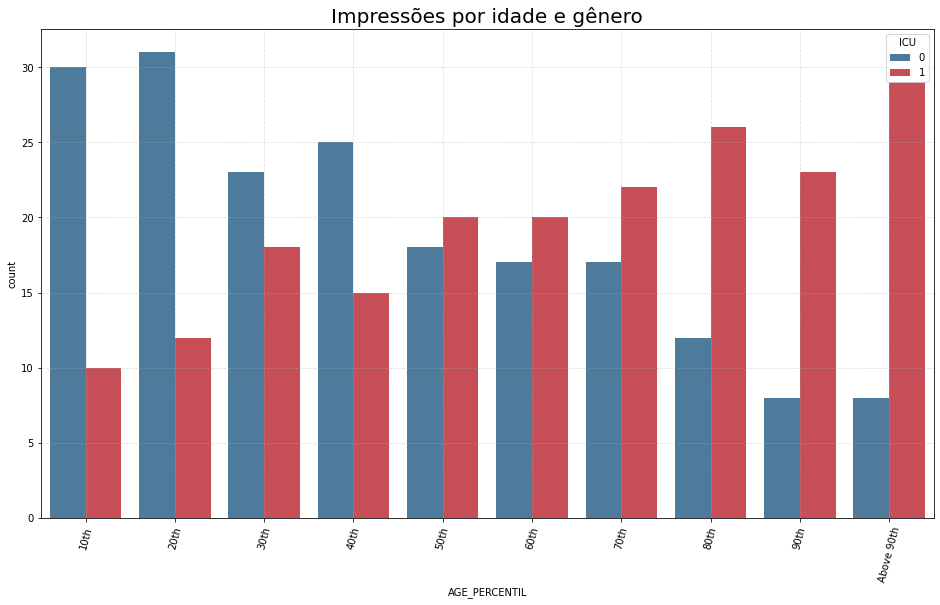

In [59]:
plot_data = dados_limpos.sort_values('AGE_PERCENTIL')
plot_x = plot_data['AGE_PERCENTIL']
hue = plot_data['ICU']

plt.figure(figsize=(16,9))

# Escolhendo a paleta de cores 
# https://medium.com/@morganjonesartist/color-guide-to-seaborn-palettes-da849406d44f
sns.set_palette((sns.diverging_palette(240, 10, n=2)))    

# Criando de fato o gráfico de barras com os dados desejados
sns.countplot(data = plot_data,
    x = plot_x,
    hue = hue,
    )

# Ajustes finais na figura
plt.xticks(rotation = 75)
plt.grid(linestyle='--', alpha = 0.4)
plt.title('Impressões por idade e gênero', fontsize = 20);

Quanto maior é a idade do paciente, mais chance ele tem de ir para a UTI logo nas duas primeiras horas de atendimento.

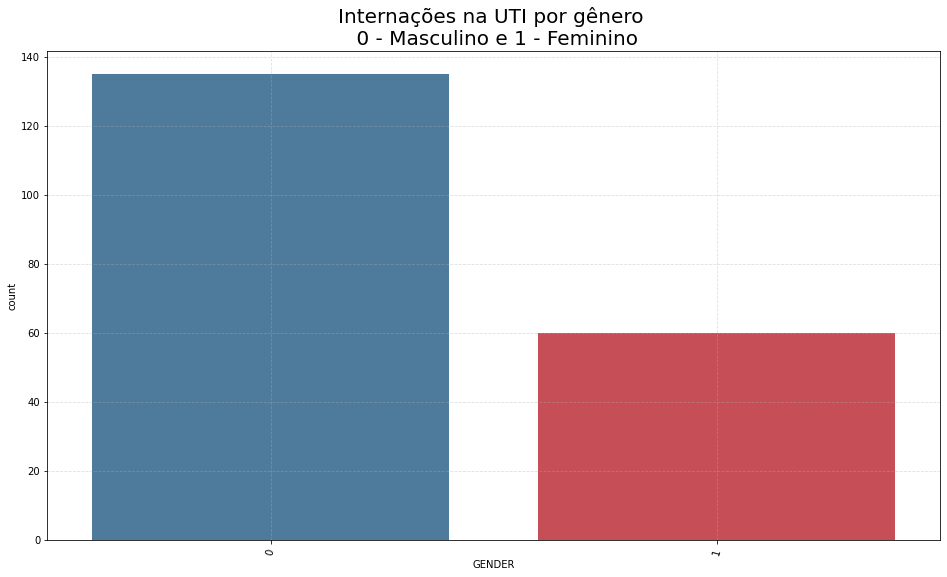

In [60]:
plot_data = dados_limpos.query('ICU == 1')
plot_x = 'GENDER'
plt.figure(figsize=(16,9))

# Escolhendo a paleta de cores 
# https://medium.com/@morganjonesartist/color-guide-to-seaborn-palettes-da849406d44f
sns.set_palette((sns.diverging_palette(240, 10, n=2)))    

# Criando de fato o gráfico de barras com os dados desejados
sns.countplot(data = plot_data,
    x = plot_x,
    )


# Ajustes finais na figura
plt.xticks(rotation = 75)
plt.grid(linestyle='--', alpha = 0.4)
plt.title('Internações na UTI por gênero \n 0 - Masculino e 1 - Feminino', fontsize = 20);

O Número de pacientes internados na UTI do sexo masculino é muito maior do que pacientes do sexo feminino, o que mostra uma clara relação entre gênero e internações na UTI.

In [61]:
dadosw2 = dados[dados['WINDOW']=='0-2']
dadosw2['ICU'].value_counts()

0    352
1     32
Name: ICU, dtype: int64

# Dummy Regression

Este modelo irá servir como Baseline, ou seja, como referência, já que qualquer modelo que tiver a perfomace inferior a este será desconsiderado nas etapas posteriores.

In [62]:
# Substituindo os valores de faixa etária por valores categóricos
dados_limpos.AGE_PERCENTIL = dados_limpos.AGE_PERCENTIL.astype("category").cat.codes


x_columns = dados.columns
y = dados_limpos["ICU"]
x = dados_limpos[x_columns].drop(["ICU","WINDOW"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 1/4, stratify=y)

modelo = DummyClassifier()
modelo.fit(X_train, y_train)

y_prediction = modelo.predict(X_test)
accuracy_score(y_test, y_prediction)

0.46875

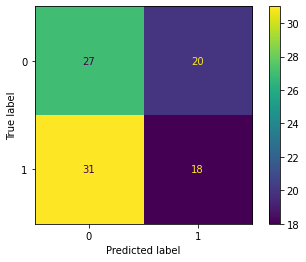

In [63]:
plot_confusion_matrix(modelo, X_test, y_test)

In [64]:
print(classification_report(y_test, y_prediction))

              precision    recall  f1-score   support

           0       0.46      0.47      0.46        47
           1       0.48      0.47      0.47        49

    accuracy                           0.47        96
   macro avg       0.47      0.47      0.47        96
weighted avg       0.47      0.47      0.47        96



# Testando vários modelos de Classificação

In [65]:
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis 
from xgboost import XGBClassifier


classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    XGBClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(),
    DummyClassifier()]

# Dicionário que irá receber o nome do modelo e a precisão obtida
acc_dict = {}


In [66]:
for clf in classifiers:
        # Obtendo o nome do classificador
        name = clf.__class__.__name__

        # Treinando o modelo    
        clf.fit(X_train,y_train)

        # Fazendo as previsões para os dados de testes
        predict=clf.predict(X_test)

        # Testando a acurácia e salvando no dicionário
        acc=accuracy_score(y_test,predict)
        if name in acc_dict:
            acc_dict[name]+=acc
        else:
            acc_dict[name]=acc

[23:21:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [67]:
# Log com os modelos e a precisão
log = pd.DataFrame(columns=['Classifier', 'Accuracy'])
# Salvando os valores obtidos em log no dicionário
log['Classifier']=acc_dict.keys()
log['Accuracy']=acc_dict.values()

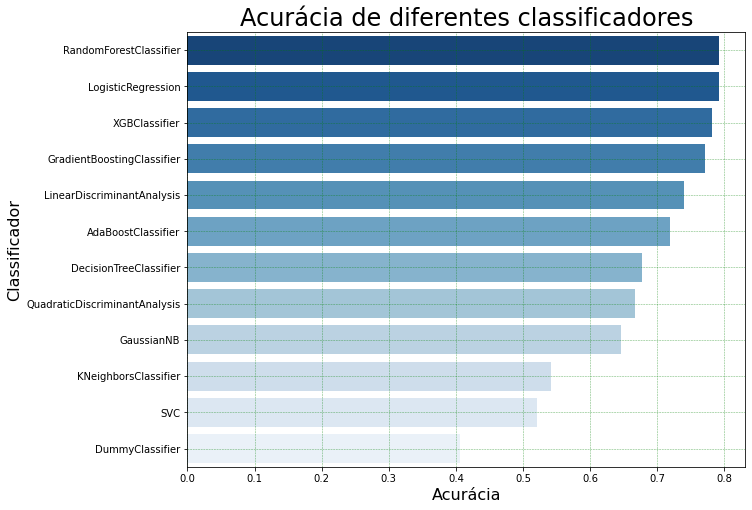

In [68]:
#log.set_index([[0,1,2,3,4,5,6,7,8,9,10,11]])
log.set_index([[int(x) for x in np.linspace(0, len(classifiers), len(classifiers))]])
%matplotlib inline

ax=plt.subplots(figsize=(10,8))
ax=sns.barplot(
    y='Classifier',
    x='Accuracy',
    data=log.sort_values('Accuracy', ascending = False),
    color='b',
    palette='Blues_r')

ax.set_xlabel('Acurácia',fontsize=16)
plt.ylabel('Classificador',fontsize=16)
plt.grid(color='g', linestyle='--', linewidth=0.5, alpha = 0.6)
plt.title('Acurácia de diferentes classificadores',fontsize=24);

# Tunning nos três melhores modelos

## Random Forest Classifier

In [69]:
from sklearn.model_selection import RandomizedSearchCV

In [70]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

rf_predict = rf.predict(X_test)
accuracy_score(y_test,rf_predict)

0.7395833333333334

In [71]:
rf = RandomForestClassifier()

n_estimators = [int(x) for x in np.linspace(100, 150, 500)]
max_depth = [int(x) for x in np.linspace(120, 150, 500)]
max_depth.append(None)
min_samples_split = [6,7,8,9,10]
min_samples_leaf = [5,6,7,8,9,10,11]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

tree_cv = RandomizedSearchCV(rf, random_grid, cv=3, n_jobs = -1, n_iter = 10)

In [72]:
tree_cv.fit(X_train,y_train)
model = tree_cv.best_estimator_
pred = model.predict(X_test)
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best accuracy is {}".format(np.sqrt(accuracy_score(pred, y_test))))

Tuned Decision Tree Parameters: {'n_estimators': 129, 'min_samples_split': 8, 'min_samples_leaf': 11, 'max_depth': 148, 'bootstrap': True}
Best accuracy is 0.8539125638299665


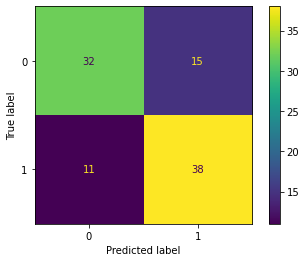

In [73]:
plot_confusion_matrix(model, X_test, y_test)

In [74]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.74      0.68      0.71        47
           1       0.72      0.78      0.75        49

    accuracy                           0.73        96
   macro avg       0.73      0.73      0.73        96
weighted avg       0.73      0.73      0.73        96



## Logistic Regression

In [75]:
lr = LogisticRegression()
lr.fit(X_train,y_train)

lr_predict = lr.predict(X_test)
accuracy_score(y_test,lr_predict)

0.7916666666666666

In [76]:
lr = LogisticRegression()
penalty = ['l1','l2', 'elasticnet']
C = [int(x) for x in np.linspace(1, 10, 10)]
max_iter = [int(x) for x in np.linspace(50,70,20)]
gs_params = {
    'penalty':penalty,
    'C':C,
    'max_iter':max_iter,
}
grid_search = GridSearchCV(lr,gs_params, n_jobs = -1)

In [77]:
# Treinando o modelo e escolhendo os melhores parâmetros
grid_search.fit(X_train,y_train)
model = grid_search.best_estimator_
pred = model.predict(X_test)

print("Tuned Decision Tree Parameters: {}".format(grid_search.best_params_))
print("Best accuracy is {}".format(np.sqrt(accuracy_score(pred, y_test))))

Tuned Decision Tree Parameters: {'C': 5, 'max_iter': 60, 'penalty': 'l2'}
Best accuracy is 0.8720187306856813


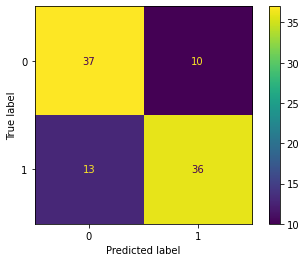

In [78]:
plot_confusion_matrix(model, X_test, y_test)

In [79]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.74      0.79      0.76        47
           1       0.78      0.73      0.76        49

    accuracy                           0.76        96
   macro avg       0.76      0.76      0.76        96
weighted avg       0.76      0.76      0.76        96



## XGB Classifier

In [80]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)

xgb_predict = xgb.predict(X_test)
accuracy_score(y_test,xgb_predict)

[23:21:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.78125

In [81]:
xgb_params = {
        'min_child_weight': [int(x) for x in np.linspace(1, 15, 15)],
        'gamma': [int(x) for x in np.linspace(0, 5, 20)],
        'subsample': [int(x) for x in np.linspace(0, 5,20)],
        'colsample_bytree': [int(x) for x in np.linspace(0, 5,20)],
        'max_depth': [int(x) for x in np.linspace(0, 5, 20)],
        }

xgb_cv = RandomizedSearchCV(xgb,xgb_params, cv = 3, n_jobs=-1, n_iter= 10)

# Testando os parâmetros
xgb_cv.fit(X_train,y_train)

model = xgb_cv.best_estimator_

[23:22:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [82]:
pred = model.predict(X_test)
print("Tuned Decision Tree Parameters: {}".format(xgb_cv.best_params_))
print("Best accuracy is {}".format(np.sqrt(accuracy_score(pred, y_test))))


Tuned Decision Tree Parameters: {'subsample': 1, 'min_child_weight': 6, 'max_depth': 2, 'gamma': 0, 'colsample_bytree': 0}
Best accuracy is 0.8955910525085282


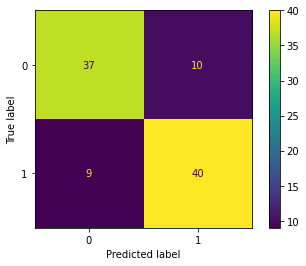

In [84]:
plot_confusion_matrix(model, X_test, y_test)

In [83]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.80      0.79      0.80        47
           1       0.80      0.82      0.81        49

    accuracy                           0.80        96
   macro avg       0.80      0.80      0.80        96
weighted avg       0.80      0.80      0.80        96



# Conclusão

# Referências

## Artigos

https://revista.ufrr.br/boca/article/view/NascimentoPacheco/2893

https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc